# Unsupervised Learning

This section marks our journey into another significant domain of machine learning and AI: unsupervised learning. Rather than delving deep into theoretical intricacies, our focus here will be on offering a practical guide. We aim to equip you with a clear understanding and effective tools for employing unsupervised learning methods in real-world (EO) scenarios.

It's important to note that, while unsupervised learning encompasses a broad range of applications, our discussion will predominantly revolve around classification tasks. This is because unsupervised learning techniques are exceptionally adept at identifying patterns and categorising data when the classifications are not explicitly labeled. By exploring these techniques, you'll gain insights into how to discern structure and relationships within your datasets, even in the absence of predefined categories or labels.

The tasks in this notebook will be mainly two:
1. Discrimination of Sea ice and lead based on image classification based on Sentinel-2 optical data.
2. Discrimination of Sea ice and lead based on altimetry data classification based on Sentinel-3 altimetry data.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
pip install rasterio

In [25]:
pip install netCDF4

## Gaussian Mixture Models (GMM) {cite}`bishop2006pattern`

### Introduction to Gaussian Mixture Models

Gaussian Mixture Models (GMM) are a probabilistic model for representing normally distributed subpopulations within an overall population. The model assumes that the data is generated from a mixture of several Gaussian distributions, each with its own mean and variance {cite}`reynolds2009gaussian, mclachlan2004finite`. GMMs are widely used for clustering and density estimation, as they provide a method for representing complex distributions through the combination of simpler ones.

### Why Gaussian Mixture Models for Clustering?

Gaussian Mixture Models are particularly powerful in scenarios where:

- **Soft clustering is needed**: Unlike K-means, GMM provides the probability of each data point belonging to each cluster, offering a soft classification and understanding of the uncertainties in our data.
- **Flexibility in cluster covariance**: GMM allows for clusters to have different sizes and different shapes, making it more flexible to capture the true variance in the data.

### Key Components of GMM

1. **Number of Components (Gaussians)**: Similar to K in K-means, the number of Gaussians (components) is a parameter that needs to be set.
2. **Expectation-Maximization (EM) Algorithm**: GMMs use the EM algorithm for fitting, iteratively improving the likelihood of the data given the model.
3. **Covariance Type**: The shape, size, and orientation of the clusters are determined by the covariance type of the Gaussians (e.g., spherical, diagonal, tied, or full covariance).

### The EM Algorithm in GMM

The Expectation-Maximization (EM) algorithm is a two-step process:

- **Expectation Step (E-step)**: Calculate the probability that each data point belongs to each cluster.
- **Maximization Step (M-step)**: Update the parameters of the Gaussians (mean, covariance, and mixing coefficient) to maximize the likelihood of the data given these assignments.

This process is repeated until convergence, meaning the parameters do not significantly change from one iteration to the next.

### Advantages of GMM

- **Soft Clustering**: Provides a probabilistic framework for soft clustering, giving more information about the uncertainties in the data assignments.
- **Cluster Shape Flexibility**: Can adapt to ellipsoidal cluster shapes, thanks to the flexible covariance structure.

### Basic Code Implementation

Below, you'll find a basic implementation of the Gaussian Mixture Model. This should serve as an initial guide for understanding the model and applying it to your data analysis projects.


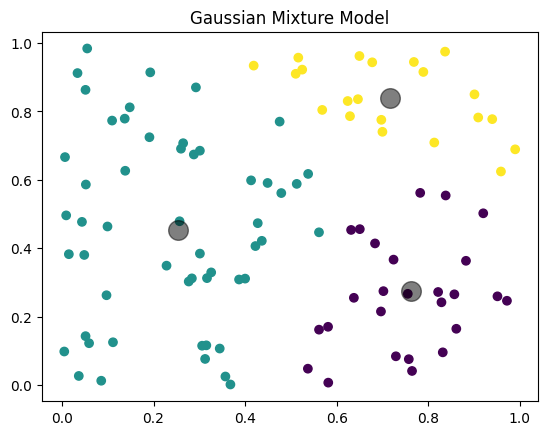

In [26]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Sample data
X = np.random.rand(100, 2)

# GMM model
gmm = GaussianMixture(n_components=3)
gmm.fit(X)
y_gmm = gmm.predict(X)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='viridis')
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Gaussian Mixture Model')
plt.show()


## Altimetry Classification
Now, let's explore the application of these unsupervised methods to altimetry classification tasks, focusing specifically on distinguishing between sea ice and leads in Sentinel-3 altimetry dataset.

### Read in Functions Needed
Before delving into the modeling process, it's crucial to preprocess the data to ensure compatibility with our analytical models. This involves transforming the raw data into meaningful variables, such as peakniness and stack standard deviation (SSD), etc.

In [27]:
#
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    # from scipy import asarray as ar,exp
    from numpy import asarray as ar, exp

    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD


In [28]:
path = '/content/drive/MyDrive/Week 4/'
SAR_file = 'S3A_SR_2_LAN_SI_20190307T005808_20190307T012503_20230527T225016_1614_042_131______LN3_R_NT_005.SEN3'
SAR_data = Dataset(path + SAR_file + '/enhanced_measurement.nc')

SAR_lat = unpack_gpod('lat_20_ku')
SAR_lon = unpack_gpod('lon_20_ku')
waves   = unpack_gpod('waveform_20_ku')
sig_0   = unpack_gpod('sig0_water_20_ku')
RIP     = unpack_gpod('rip_20_ku')
flag = unpack_gpod('surf_type_class_20_ku')

# Filter out bad data points using criteria (here, lat >= -99999)
find = np.where(SAR_lat >= -99999)
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
waves   = waves[find]
sig_0   = sig_0[find]
RIP     = RIP[find]

# Calculate additional features
PP = peakiness(waves)
SSD = calculate_SSD(RIP)

# Convert to numpy arrays (if not already)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP)
SSD_np   = np.array(SSD)

# Create data matrix
data = np.column_stack((sig_0_np, PP_np, SSD_np))

# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

Running peakiness function...


/tmp/ipython-input-448542667.py:63: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


There are some NaN values in the dataset so one way to deal with this is to delete them.

In [29]:
# Remove any rows that contain NaN values
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]

mask = ~np.isnan(data_normalized).any(axis=1)
waves_cleaned = np.array(waves)[mask]
flag_cleaned = np.array(flag)[mask]

data_cleaned = data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]


Number of NaN values in the array: 1283


Now, let's proceed with running the GMM model as usual. Remember, you have the flexibility to substitute this with K-Means or any other preferred model.

In [30]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)

We can also inspect how many data points are there in each class of your clustering prediction.

In [31]:
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

Cluster counts: {np.int64(0): np.int64(8880), np.int64(1): np.int64(3315)}


 Echoes can be extracted and plotted: sea ice echos as '0' and lead echos as '1'

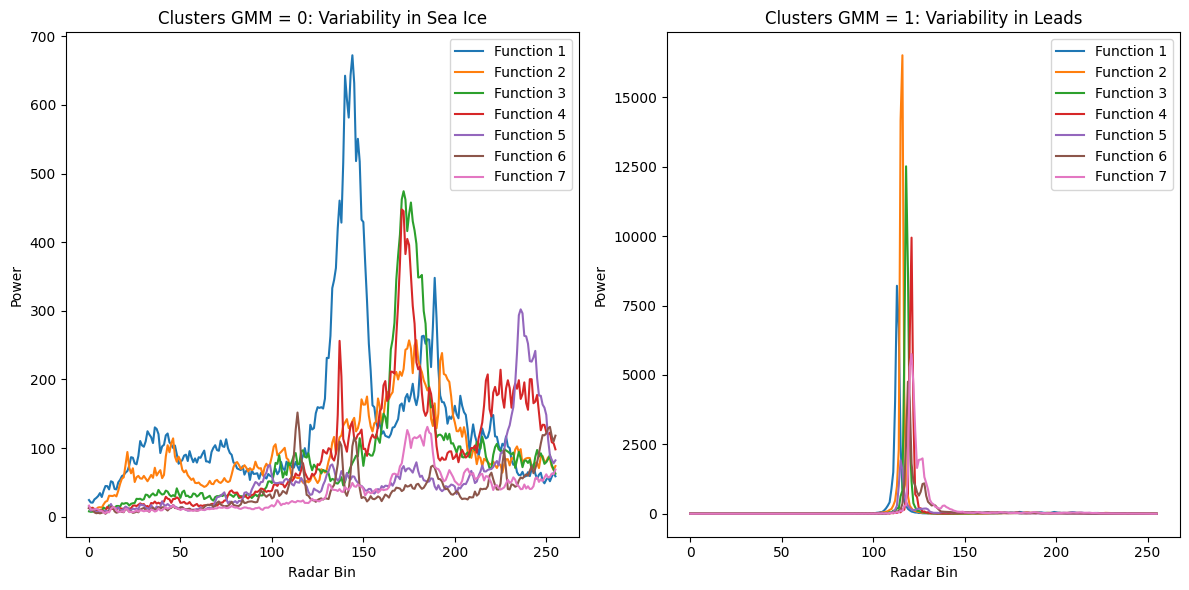

In [32]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot first 7 functions where clusters_gmm is equal to 0
functions_to_plot_0 = waves_cleaned[clusters_gmm == 0][:7]
for i, function in enumerate(functions_to_plot_0):
    axs[0].plot(function, label=f'Function {i+1}')

# Plot first 7 functions where clusters_gmm is equal to 1
functions_to_plot_1 = waves_cleaned[clusters_gmm == 1][:7]
for i, function in enumerate(functions_to_plot_1):
    axs[1].plot(function, label=f'Function {i+1}')

# Set titles
axs[0].set_title('Clusters GMM = 0: Variability in Sea Ice')
axs[1].set_title('Clusters GMM = 1: Variability in Leads')

# Set axis labels
for ax in axs:
    ax.set_xlabel('Radar Bin')
    ax.set_ylabel('Power')

# Add legends
axs[0].legend()
axs[1].legend()

# Adjust layout and show
plt.tight_layout()
plt.show()

We can plot the mean waveform and standard deviation of each class.

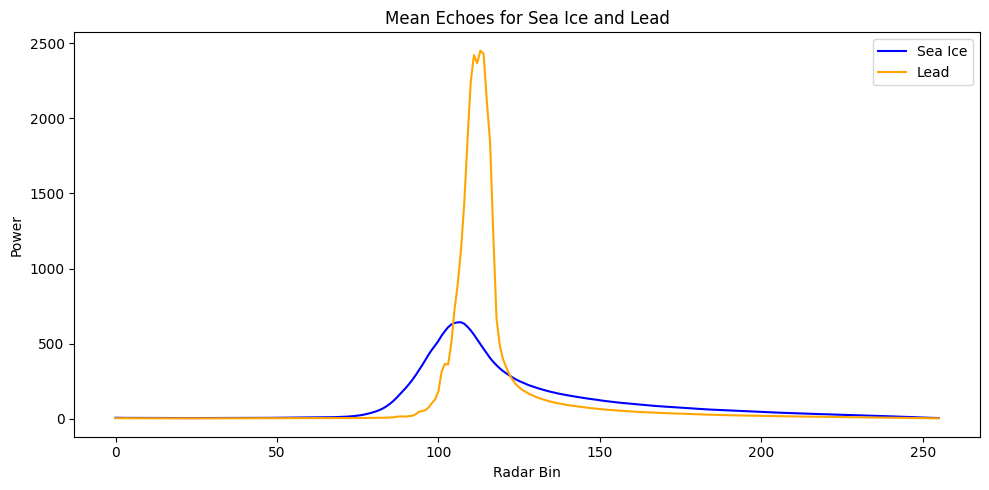

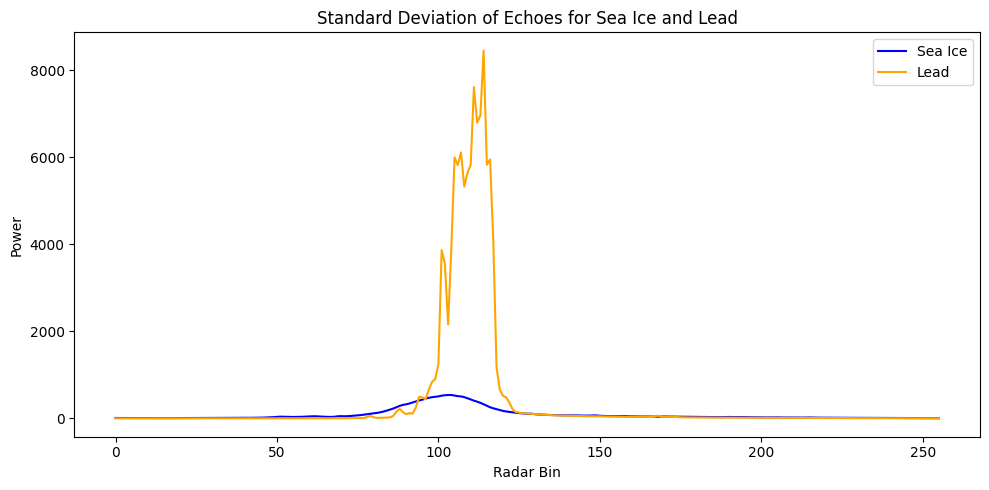

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean and standard deviation for Sea Ice and Leads
mean_ice = np.mean(waves_cleaned[clusters_gmm==0], axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0], axis=0)

mean_lead = np.mean(waves_cleaned[clusters_gmm==1], axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1], axis=0)

# --- Plot Means ---
plt.figure(figsize=(10,5))
plt.plot(mean_ice, label='Sea Ice', color='blue')
plt.plot(mean_lead, label='Lead', color='orange')
plt.title('Mean Echoes for Sea Ice and Lead')
plt.xlabel('Radar Bin')
plt.ylabel('Power')
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Standard Deviations ---
plt.figure(figsize=(10,5))
plt.plot(std_ice, label='Sea Ice', color='blue')
plt.plot(std_lead, label='Lead', color='orange')
plt.title('Standard Deviation of Echoes for Sea Ice and Lead')
plt.xlabel('Radar Bin')
plt.ylabel('Power')
plt.legend()
plt.tight_layout()
plt.show()

## Physical Waveform Alignment

To compare waveforms on a common footing we can **align** them using the known orbit geometry. This physically-based approach was developed at the [Alfred Wegener Institute (AWI)](https://gitlab.awi.de/siteo/aligned-waveform-generator).



In [ ]:
# ============================================================
# Physical Waveform Alignment (AWI-style)
# ============================================================

from scipy.interpolate import interp1d

# --- Step 1: Read alignment variables from the NetCDF file ---
print("Reading alignment variables...")
tracker_range_all = unpack_gpod('tracker_range_20_ku')
altitude_all      = unpack_gpod('alt_20_ku')
mss_all           = unpack_gpod('mean_sea_surf_sol1_20_ku')

# Sum atmospheric and geophysical range corrections (1 Hz → 20 Hz).
# We use a dedicated interpolation that filters NaN before fitting,
# because unpack_gpod can fail on masked 1 Hz arrays in newer SciPy.
correction_names = [
    'mod_dry_tropo_cor_zero_altitude_01',
    'mod_wet_tropo_cor_zero_altitude_01',
    'iono_cor_gim_01_ku',
    'ocean_tide_sol1_01',
    'load_tide_sol1_01',
    'pole_tide_01',
    'solid_earth_tide_01',
]

def safe_interp_1hz(var_name, n_20hz):
    """Read a 1 Hz variable and interpolate to 20 Hz, handling NaN."""
    vals = np.array(SAR_data.variables[var_name][:], dtype=float)
    if hasattr(vals, 'filled'):
        vals = np.ma.filled(vals, np.nan)
    time_1hz  = np.array(SAR_data.variables['time_01'][:], dtype=float)
    time_20hz = np.array(SAR_data.variables['time_20_ku'][:], dtype=float)
    valid = ~np.isnan(vals)
    if np.sum(valid) < 2:
        return np.zeros(n_20hz)
    f = interp1d(time_1hz[valid], vals[valid], kind='linear',
                 fill_value='extrapolate')
    return f(time_20hz)

n_20hz = len(tracker_range_all)
total_correction_all = np.zeros(n_20hz)
for name in correction_names:
    try:
        total_correction_all += safe_interp_1hz(name, n_20hz)
    except Exception as e:
        print(f"  Skipping {name}: {e}")

# --- Step 2: Apply the same filters used for waves_cleaned ---
# (find → NaN mask → sea-ice/lead flag filter)
_flag_filt = np.array(flag)[find][mask]
ice_lead_filt = (_flag_filt == 1) | (_flag_filt == 2)

tracker_range_c = tracker_range_all[find][mask][ice_lead_filt]
altitude_c      = altitude_all[find][mask][ice_lead_filt]
mss_c           = mss_all[find][mask][ice_lead_filt]
correction_c    = total_correction_all[find][mask][ice_lead_filt]

# --- Step 3: Compute the alignment shift for each waveform ---
alignment_m = altitude_c - tracker_range_c - correction_c - mss_c

print(f"\nRaw alignment shifts ({len(alignment_m)} waveforms):")
print(f"  Mean:  {np.nanmean(alignment_m):.3f} m")
print(f"  Std:   {np.nanstd(alignment_m):.3f} m")
print(f"  Range: [{np.nanmin(alignment_m):.3f}, {np.nanmax(alignment_m):.3f}] m")

# Clip outliers: shifts far from the bulk arise from poor MSS or
# correction data at high latitudes.  Keep the central 98 %.
finite = np.isfinite(alignment_m)
p1, p99 = np.nanpercentile(alignment_m[finite], [1, 99])
outlier = (~finite) | (alignment_m < p1) | (alignment_m > p99)
alignment_m[outlier] = 0.0

# Remove the mean offset so we only correct for *differential* alignment.
# The mean shift is dominated by average freeboard / MSS bias, not by
# waveform-to-waveform tracker variation.
nonzero = alignment_m != 0
alignment_m[nonzero] -= np.mean(alignment_m[nonzero])

print(f"After clipping + de-meaning ({np.sum(outlier)} outliers zeroed):")
print(f"  Std:   {np.nanstd(alignment_m):.3f} m")

# --- Step 4: Define alignment helper functions ---
RANGE_GATE_RES = 0.2342   # metres per range bin (Sentinel-3 Ku-band)

def fft_oversample(waveform, factor):
    """Oversample a waveform using FFT zero-padding."""
    n = len(waveform)
    n_os = n * factor
    ft = np.fft.fftshift(np.fft.fft(np.nan_to_num(waveform)))
    pad = int(np.floor(n_os / 2 - n / 2))
    ft_padded = np.concatenate([np.zeros(pad), ft, np.zeros(pad)])
    return np.real(np.fft.ifft(np.fft.fftshift(ft_padded))) * n_os / n

def align_single_waveform(waveform, shift_m, n_bins, resolution, os_factor):
    """Shift a single waveform by shift_m metres via FFT oversampling."""
    wf_os = fft_oversample(waveform, os_factor)
    x_m = np.linspace(0, n_bins * resolution, len(wf_os), endpoint=False)
    shifted = np.interp(x_m + shift_m, x_m, wf_os)
    return shifted[::os_factor]          # decimate back to original bins

# --- Step 5: Normalise and align all cleaned waveforms ---
n_bins = waves_cleaned.shape[1]
os_factor = int(np.ceil(RANGE_GATE_RES * 100))   # ~24x for ~1 cm resolution

# Per-waveform normalisation to [0, 1]
wf_max = np.nanmax(waves_cleaned, axis=1, keepdims=True).astype(float)
wf_max[wf_max == 0] = 1
waves_norm = waves_cleaned / wf_max

print(f"\nAligning {len(waves_norm)} waveforms (oversample x{os_factor}) ...")
waves_aligned = np.zeros_like(waves_norm)
for i in range(len(waves_norm)):
    shift = alignment_m[i]
    if np.isnan(shift):
        shift = 0.0
    waves_aligned[i] = align_single_waveform(
        waves_norm[i], shift, n_bins, RANGE_GATE_RES, os_factor)

# Quick summary: peak-position improvement
peaks_before = np.argmax(waves_norm, axis=1)
peaks_after  = np.argmax(waves_aligned, axis=1)
print(f"\nPeak position std:   {np.std(peaks_before):.2f}  ->  {np.std(peaks_after):.2f} bins")

Reading alignment variables...

Raw alignment shifts (12195 waveforms):
  Mean:  4.169 m
  Std:   3.739 m
  Range: [-27.545, 76.854] m
After clipping + de-meaning (2934 outliers zeroed):
  Std:   1.897 m

Aligning 12195 waveforms (oversample x24) ...

Peak position std:   10.77  ->  8.19 bins


/usr/local/lib/python3.12/dist-packages/msalign/utilities.py:106: UserWarning: The input array was rotated to match the x-axis input
  warnings.warn("The input array was rotated to match the x-axis input", UserWarning)


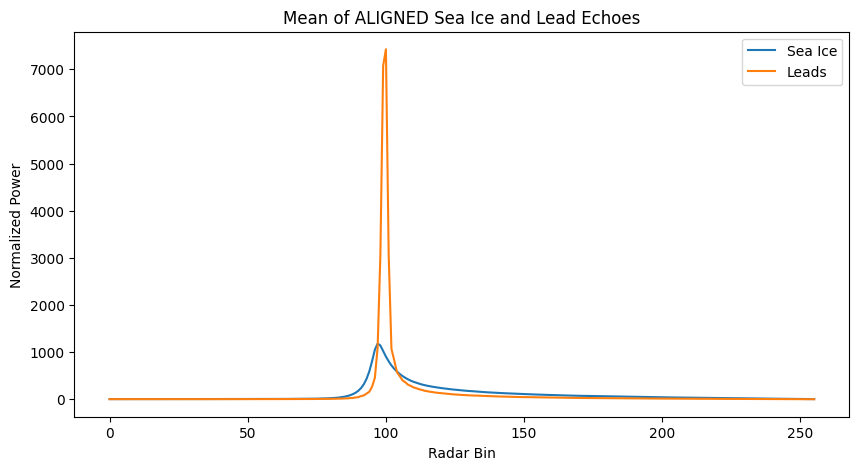

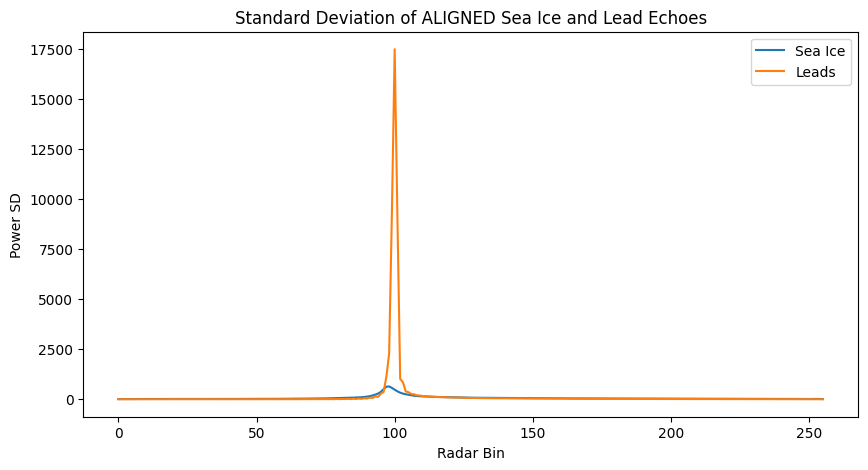

In [ ]:
!pip install msalign
from msalign import msalign
import matplotlib.pyplot as plt
import numpy as np

# --- Set up range and reference bin for alignment ---
r = np.arange(waves_cleaned.shape[1])  # 0 to 255 for 256 bins
reference = [100]  # align all waveforms to bin 100

# --- Align waveforms ---
aligned_sea_ice = msalign(r, waves_cleaned[clusters_gmm==0].T, reference)
aligned_leads    = msalign(r, waves_cleaned[clusters_gmm==1].T, reference)

# --- Plot mean of aligned waveforms ---
plt.figure(figsize=(10,5))
plt.plot(np.mean(aligned_sea_ice, axis=0), label='Sea Ice')
plt.plot(np.mean(aligned_leads, axis=0), label='Leads')
plt.title('Mean of ALIGNED Sea Ice and Lead Echoes')
plt.xlabel('Radar Bin')
plt.ylabel('Normalized Power')
plt.legend()
plt.show()

# --- Plot standard deviation of aligned waveforms ---
plt.figure(figsize=(10,5))
plt.plot(np.std(aligned_sea_ice, axis=0), label='Sea Ice')
plt.plot(np.std(aligned_leads, axis=0), label='Leads')
plt.title('Standard Deviation of ALIGNED Sea Ice and Lead Echoes')
plt.xlabel('Radar Bin')
plt.ylabel('Power SD')
plt.legend()
plt.show()

## Scatter Plots of Clustered Data

This code visualizes the clustering results using scatter plots, where different colors represent different clusters (`clusters_gmm`).

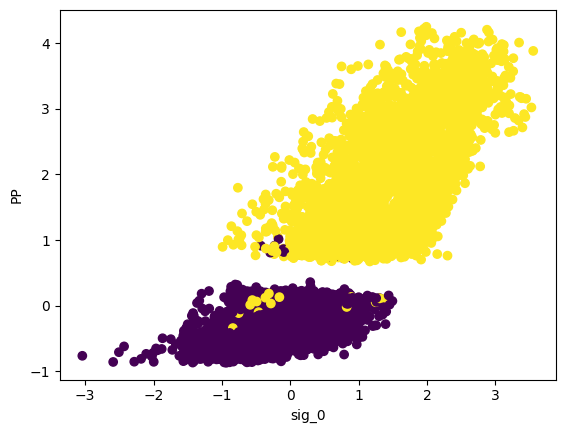

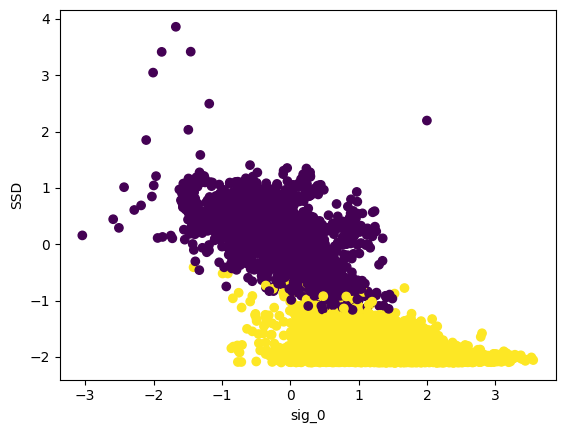

Text(0, 0.5, 'SSD')

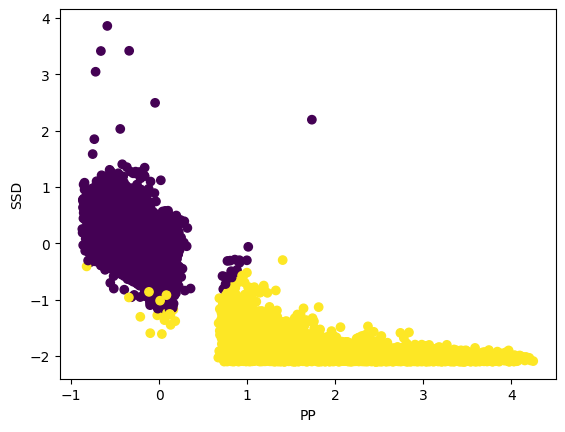

In [ ]:
plt.scatter(data_cleaned[:,0],data_cleaned[:,1],c=clusters_gmm)
plt.xlabel("sig_0")
plt.ylabel("PP")
plt.show()
plt.scatter(data_cleaned[:,0],data_cleaned[:,2],c=clusters_gmm)
plt.xlabel("sig_0")
plt.ylabel("SSD")
plt.show()
plt.scatter(data_cleaned[:,1],data_cleaned[:,2],c=clusters_gmm)
plt.xlabel("PP")
plt.ylabel("SSD")

## Compare with ESA data
In the ESA dataset, sea ice = 1 and lead = 2. Therefore, we need to subtract 1 from it so our predicted labels are comparable with the official product labels.

In [ ]:
flag_cleaned_modified = flag_cleaned - 1

Confusion Matrix (numeric):
[[8856   22]
 [  24 3293]]

Classification Report:
              precision    recall  f1-score   support

     Sea Ice       1.00      1.00      1.00      8878
        Lead       0.99      0.99      0.99      3317

    accuracy                           1.00     12195
   macro avg       1.00      1.00      1.00     12195
weighted avg       1.00      1.00      1.00     12195



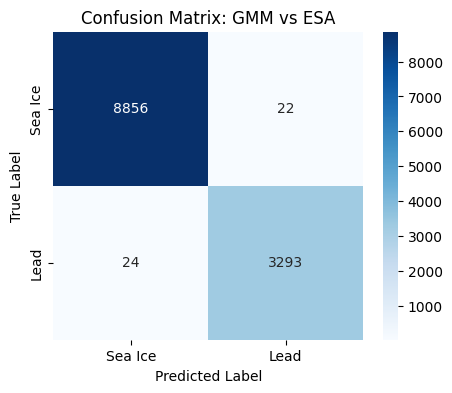

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Adjust ESA labels to match GMM clusters ---
# ESA: sea ice = 1, lead = 2 → subtract 1 to get sea ice = 0, lead = 1
true_labels = flag_cleaned - 1
predicted_gmm = clusters_gmm

# --- Compute confusion matrix ---
conf_matrix = confusion_matrix(true_labels, predicted_gmm)
print("Confusion Matrix (numeric):")
print(conf_matrix)

# --- Classification report ---
class_report = classification_report(true_labels, predicted_gmm, target_names=['Sea Ice','Lead'])
print("\nClassification Report:")
print(class_report)

# --- Plot visual confusion matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sea Ice','Lead'], yticklabels=['Sea Ice','Lead'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: GMM vs ESA')
plt.show()